In [1]:
# https://keras.io/examples/vision/handwriting_recognition
# https://keras.io/examples/vision/captcha_ocr
import sys
import tensorflow as tf
sys.path.append('..')
tf.get_logger().setLevel('ERROR')

# Check GPU working

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0': raise SystemError('GPU device not found')
print('Found GPU at:', device_name)
!nvcc -V

Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Nov_30_19:15:10_Pacific_Standard_Time_2020
Cuda compilation tools, release 11.2, V11.2.67
Build cuda_11.2.r11.2/compiler.29373293_0


# Import the dataset

In [4]:
from dataset import create_dataset, remove_rare_chars
DATA_PATH = '../../Dataset/trdg'
FONT_PATH = '../../Dataset/NomNaTong-Regular.ttf'
HEIGHT = 148
WIDTH = 32

## Load and remove records with rare characters 

In [5]:
img_paths, labels, vocabs = create_dataset(DATA_PATH)
img_paths, labels, vocabs = remove_rare_chars(img_paths, labels, vocabs, threshold=2)
print('Number of images found:', len(img_paths))
print('Number of labels found:', len(labels))
print('Number of unique characters:', len(vocabs))
print('Characters present:', vocabs, sep='')

Number of images found: 3487
Number of labels found: 3487
Number of unique characters: 2161
Characters present:{'㐌': 316, '浪': 300, '朱': 247, '\U000f047c': 214, '\U000f070b': 213, '尼': 210, '吏': 200, '𦋦': 197, '𢚸': 197, '娘': 197, '𠊛': 192, '固': 189, '拱': 172, '之': 167, '情': 161, '埃': 161, '買': 151, '芇': 146, '𠬠': 145, '仙': 139, '欺': 138, '群': 136, '𠳒': 136, '麻': 130, '𠓨': 127, '𧗱': 124, '爫': 122, '別': 118, '塘': 117, '花': 114, '𠫾': 109, '𠄩': 108, '払': 106, '渚': 106, '𡗶': 106, '浽': 104, '傷': 103, '強': 102, '呐': 101, '渃': 99, '𦖑': 99, '饒': 97, '庒': 97, '如': 96, '些': 95, '分': 94, '冲': 94, '畧': 93, '咍': 92, '鐄': 90, '時': 90, '昆': 90, '低': 90, '𢬣': 89, '𡢐': 88, '身': 87, '兜': 87, '𧡊': 86, '於': 86, '細': 84, '生': 81, '月': 79, '公': 78, '戈': 78, '皮': 78, '調': 76, '﨤': 74, '𣈜': 74, '爲': 73, '茹': 73, '沛': 73, '牢': 73, '仍': 73, '油': 73, '命': 72, '排': 70, '典': 66, '包': 66, '娥': 65, '碎': 65, '㗂': 64, '\U000f061a': 63, '雲': 62, '𠁀': 61, '\U000f02c7': 61, '恩': 61, '迻': 59, '耒': 59, '茄': 57, '共': 57, '紅'

## Visualize the data

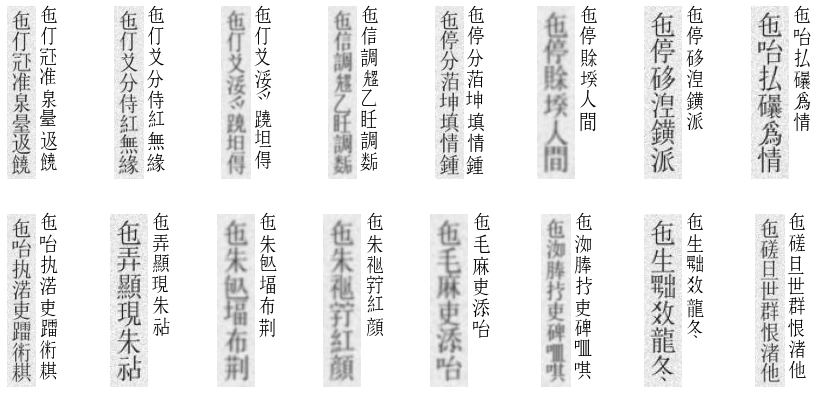

In [6]:
from visualizer import visualize_images_labels
visualize_images_labels(img_paths, labels, font_path=FONT_PATH, text_x=WIDTH + 3)

## Building the character vocabulary

In [7]:
# Mapping characters to integers
char2num = tf.keras.layers.StringLookup(
    vocabulary = list(vocabs), 
    mask_token = None,
    encoding = 'utf-8'
)

# Mapping integers back to original characters
num2char = tf.keras.layers.StringLookup(
    vocabulary = char2num.get_vocabulary(), 
    mask_token = None, 
    invert = True,
    encoding = 'utf-8'
)

# Define the model

In [8]:
from ctc import CTCLayer
from cnn import custom_cnn, imagenet_model
from tensorflow.keras.layers import Input, Dense, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [9]:
def build_and_compile_model(name):
    image_input = Input(shape=(HEIGHT, WIDTH, 1), dtype='float32', name='image')
    label_input = Input(shape=(None,), dtype='int64', name='label')
    label_length = Input(shape=[1], dtype='int64', name='label_length')

    ## CNN layers
    conv_blocks_config = {
        'block1': {'num_conv': 1, 'filters':  64, 'pool_size': (2, 2)}, 
        'block2': {'num_conv': 1, 'filters': 128, 'pool_size': (2, 2)}, 
        'block3': {'num_conv': 2, 'filters': 256, 'pool_size': (2, 2)}, 
        'block4': {'num_conv': 2, 'filters': 512, 'pool_size': (1, 2)}, 
    }
    x = custom_cnn(conv_blocks_config, image_input)

    # RNN layers
    bigru_layers = [512, 512]
    for idx in range(len(bigru_layers)):
        x = Bidirectional(GRU(
            units = bigru_layers[idx], 
            return_sequences = True, 
            dropout = 0.2,
        ), name = f'bigru{idx + 1}')(x)

    # Output layer
    y_pred = Dense(
        units = char2num.vocabulary_size() + 1, # + 1 blank character for CTC
        activation = 'softmax', 
        name = 'rnn_output'
    )(x)

    # Compile the model and return
    model = Model(
        inputs = [image_input, label_input, label_length], 
        outputs = CTCLayer()(label_input, y_pred, label_length), 
        name = name
    )
    model.compile(optimizer=Adam(learning_rate=2e-4))
    return model

# Training

In [10]:
from image_pipeline import preprocess_image
MAX_LENGTH = max([len(label) for label in labels])
PADDING_TOKEN = char2num.vocabulary_size()
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

## Callbacks

In [11]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from custom_callbacks import EditDistanceCallback, EarlyStoppingWithStuck
early_stopping_callback = EarlyStoppingWithStuck(patience=5)

def scheduler(epoch, lr):
    if epoch == 0 or (epoch % 10) > 0: return lr # Keeps lr for 10 epochs
    return lr * tf.math.exp(-0.2) # Decreases it exponentially after that
schedule_lr_callback = LearningRateScheduler(scheduler, verbose=1)

# Reduce the learning rate once learning stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2, # Reduce if no improvement after 2 epochs
    min_delta = 0.001, # The val_loss should at least improve 0.001
    factor = 0.5, # => new_lr = lr * factor
    verbose = 1
)

## Data input pipeline

In [12]:
def process_images_labels(img_path, label, img_size=(HEIGHT, WIDTH)):
    image = preprocess_image(img_path, img_size)
    label = char2num(tf.strings.unicode_split(label, input_encoding='UTF-8'))
    label_length = tf.shape(label, tf.int64)[0]
    label = tf.pad(
        label, 
        paddings = [[0, MAX_LENGTH - label_length]], 
        constant_values = PADDING_TOKEN
    )
    return {'image': image, 'label': label, 'label_length': label_length} 

In [13]:
def prepare_tf_dataset(img_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

## Cross validation with K-Fold

In [14]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True)
valid_datasets = []
best_epochs = []
edist_logs = []
histories = []
models = []

In [15]:
%%time
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(img_paths, labels)):
    train_tf_dataset = prepare_tf_dataset(img_paths[train_idx], labels[train_idx])
    valid_tf_dataset = prepare_tf_dataset(img_paths[valid_idx], labels[valid_idx])
    valid_datasets.append((valid_tf_dataset, valid_idx))
    
    model = build_and_compile_model(f'Model_{fold_idx + 1}')
    edit_distance_callback = EditDistanceCallback(Model(
        inputs = model.get_layer('image').input, 
        outputs = model.get_layer('rnn_output').output
    ), valid_tf_dataset, MAX_LENGTH) 
    
    print(f'Start training for Fold {fold_idx + 1}:')
    history = model.fit(
        train_tf_dataset,
        validation_data = valid_tf_dataset,
        epochs = 100,
        callbacks = [
#             checkpoint_callback,
#             schedule_lr_callback, 
            reduce_lr_callback, 
            edit_distance_callback, 
            early_stopping_callback,
        ],
        verbose = 1
    )
    print(f'Finish training for Fold {fold_idx + 1}\n')
    best_epochs.append(early_stopping_callback.best_epoch)
    edist_logs.append(edit_distance_callback.logs)
    histories.append(history)
    models.append(model)

Start training for Fold 1:
Epoch 1/100
197/197 [==============================] - 15s 46ms/step - loss: 52.3782 - val_loss: 52.6487 - lr: 2.0000e-04
Epoch 2/100
197/197 [==============================] - 6s 31ms/step - loss: 46.5705 - val_loss: 47.2269 - lr: 2.0000e-04
Epoch 3/100
197/197 [==============================] - 6s 31ms/step - loss: 41.8947 - val_loss: 44.7893 - lr: 2.0000e-04
Epoch 4/100
197/197 [==============================] - 6s 31ms/step - loss: 36.2611 - val_loss: 42.3963 - lr: 2.0000e-04
Epoch 5/100
197/197 [==============================] - 6s 31ms/step - loss: 30.0838 - val_loss: 37.9010 - lr: 2.0000e-04
Epoch 6/100
197/197 [==============================] - 6s 31ms/step - loss: 24.1868 - val_loss: 34.6951 - lr: 2.0000e-04
Epoch 7/100
197/197 [==============================] - 6s 31ms/step - loss: 19.0390 - val_loss: 33.8098 - lr: 2.0000e-04
Epoch 8/100
197/197 [==============================] - 6s 31ms/step - loss: 14.7028 - val_loss: 31.5825 - lr: 2.0000e-04
Epoc

197/197 [==============================] - 6s 31ms/step - loss: 0.0791 - val_loss: 4.1102 - lr: 2.0000e-04
Epoch 19/100
197/197 [==============================] - 6s 32ms/step - loss: 0.0683 - val_loss: 4.0630 - lr: 2.0000e-04
Epoch 20/100
197/197 [==============================] - 6s 31ms/step - loss: 0.0591 - val_loss: 4.0026 - lr: 2.0000e-04
Epoch 21/100
197/197 [==============================] - 6s 31ms/step - loss: 0.0514 - val_loss: 3.9842 - lr: 2.0000e-04
Epoch 22/100
197/197 [==============================] - 6s 32ms/step - loss: 0.0451 - val_loss: 3.9893 - lr: 2.0000e-04
Epoch 23/100
197/197 [==============================] - 6s 32ms/step - loss: 0.0398 - val_loss: 3.9475 - lr: 2.0000e-04
Epoch 24/100
197/197 [==============================] - 6s 32ms/step - loss: 0.0352 - val_loss: 3.9631 - lr: 2.0000e-04
Epoch 25/100
197/197 [==============================] - 6s 32ms/step - loss: 0.0315 - val_loss: 3.9462 - lr: 2.0000e-04
Epoch 26/100
197/197 [==============================]

Epoch 9/100
197/197 [==============================] - 7s 33ms/step - loss: 11.9155 - val_loss: 30.2472 - lr: 2.0000e-04
Epoch 10/100
195/197 [============================>.] - ETA: 0s - loss: 8.5981 - Mean edit distance: 6.2478147
Restored weights from the end of epoch: 5
197/197 [==============================] - 6s 32ms/step - loss: 8.5922 - val_loss: 29.5688 - lr: 2.0000e-04
Epoch 10: early stopping
Finish training for Fold 5

Start training for Fold 6:
Epoch 1/100
197/197 [==============================] - 12s 42ms/step - loss: 52.3953 - val_loss: 52.0978 - lr: 2.0000e-04
Epoch 2/100
197/197 [==============================] - 6s 32ms/step - loss: 46.6488 - val_loss: 46.9620 - lr: 2.0000e-04
Epoch 3/100
197/197 [==============================] - 6s 32ms/step - loss: 42.7992 - val_loss: 44.8990 - lr: 2.0000e-04
Epoch 4/100
197/197 [==============================] - 6s 32ms/step - loss: 37.9952 - val_loss: 41.9513 - lr: 2.0000e-04
Epoch 5/100
197/197 [==============================] 

Epoch 5/100
197/197 [==============================] - 6s 32ms/step - loss: 31.1371 - val_loss: 41.5518 - lr: 2.0000e-04
Epoch 6/100
197/197 [==============================] - 6s 31ms/step - loss: 25.5565 - val_loss: 39.8343 - lr: 2.0000e-04
Epoch 7/100
197/197 [==============================] - 6s 31ms/step - loss: 20.6240 - val_loss: 37.6304 - lr: 2.0000e-04
Epoch 8/100
197/197 [==============================] - 6s 31ms/step - loss: 16.2442 - val_loss: 37.6326 - lr: 2.0000e-04
Epoch 9/100
197/197 [==============================] - ETA: 0s - loss: 12.4926 - Mean edit distance: 6.9573865
Restored weights from the end of epoch: 4
197/197 [==============================] - 6s 31ms/step - loss: 12.4926 - val_loss: 35.1632 - lr: 2.0000e-04
Epoch 9: early stopping
Finish training for Fold 9

Start training for Fold 10:
Epoch 1/100
197/197 [==============================] - 12s 41ms/step - loss: 52.3322 - val_loss: 53.6695 - lr: 2.0000e-04
Epoch 2/100
197/197 [==============================]

## Get the best CRNN model and its results

In [27]:
best_loss = float('inf')
for fold_idx, model in enumerate(models):
    final_edist = edist_logs[fold_idx][best_epochs[fold_idx]]
    print('Fold', fold_idx + 1, '- Mean edit distance:', final_edist)
    final_val_loss = model.evaluate(valid_datasets[fold_idx][0], verbose=1)
    if final_val_loss < best_loss:
        best_loss = final_val_loss
        best_fold_idx = fold_idx

Fold 1 - Mean edit distance: 7.3822117
22/22 [==============================] - 0s 14ms/step - loss: 37.9010
Fold 2 - Mean edit distance: 7.439467
22/22 [==============================] - 0s 13ms/step - loss: 39.9611
Fold 3 - Mean edit distance: 1.6520978
22/22 [==============================] - 0s 13ms/step - loss: 3.8845
Fold 4 - Mean edit distance: 7.5122375
22/22 [==============================] - 0s 14ms/step - loss: 39.2654
Fold 5 - Mean edit distance: 7.490385
22/22 [==============================] - 0s 13ms/step - loss: 40.4044
Fold 6 - Mean edit distance: 7.8037586
22/22 [==============================] - 0s 13ms/step - loss: 41.8911
Fold 7 - Mean edit distance: 7.6844406
22/22 [==============================] - 0s 14ms/step - loss: 43.3987
Fold 8 - Mean edit distance: 7.215909
22/22 [==============================] - 0s 13ms/step - loss: 36.7559
Fold 9 - Mean edit distance: 7.6884465
22/22 [==============================] - 0s 13ms/step - loss: 42.7807
Fold 10 - Mean edit dis

In [28]:
best_model = models[best_fold_idx]
best_model.save('crnn_trdg.h5')
best_model.summary()

Model: "Model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 148, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 block1_conv1 (Conv2D)          (None, 148, 32, 64)  640         ['image[0][0]']                  
                                                                                                  
 block1_bn1 (BatchNormalization  (None, 148, 32, 64)  256        ['block1_conv1[0][0]']           
 )                                                                                                
                                                                                            

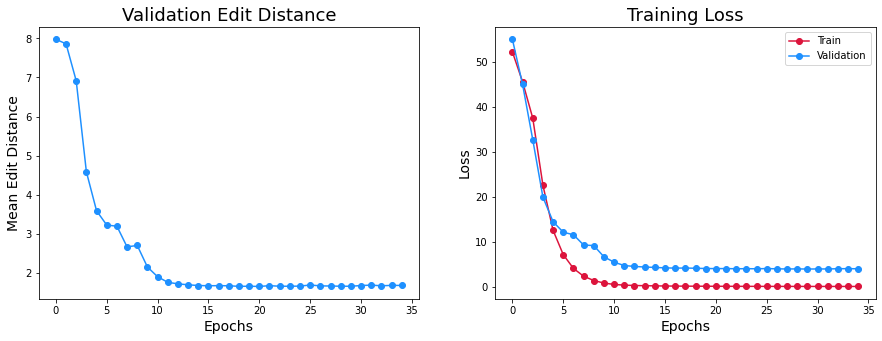

In [29]:
from visualizer import plot_training_results
plot_training_results(
    histories[best_fold_idx], 
    edist_logs[best_fold_idx], 
    save_name = 'crnn_trdg_history.png'
)

# Inference

## Reload the model

In [30]:
from tensorflow.keras.models import Model, load_model
from ctc import CTCLayer, decode_batch_predictions

In [31]:
reloaded_model = load_model('crnn_trdg.h5', custom_objects={'CTCLayer': CTCLayer})
reloaded_prediction_model = Model(
    inputs = reloaded_model.get_layer('image').input, 
    outputs = reloaded_model.get_layer('rnn_output').output
)
reloaded_model.summary(line_length=100)

Model: "Model_3"
____________________________________________________________________________________________________
 Layer (type)                    Output Shape          Param #     Connected to                     
 image (InputLayer)              [(None, 148, 32, 1)]  0           []                               
                                                                                                    
 block1_conv1 (Conv2D)           (None, 148, 32, 64)   640         ['image[0][0]']                  
                                                                                                    
 block1_bn1 (BatchNormalization)  (None, 148, 32, 64)  256         ['block1_conv1[0][0]']           
                                                                                                    
 block1_activation1 (LeakyReLU)  (None, 148, 32, 64)   0           ['block1_bn1[0][0]']             
                                                                          

## On test dataset

In [117]:
best_valid_dataset = valid_datasets[best_fold_idx][0]
best_valid_idxs = valid_datasets[best_fold_idx][1]

Batch 1: ['㐌停𥒥\U000f07ba鐄派', '㐌朱𠓨堛布荆', '㐌朱𥙩𫳘紅顔', '㐌𤷱昆𬑉方𡗶\U000f0761\U000f0761', '㐌𧵆之固調車', '㗂寬如𩙌倘外', '㝵芇亇渃及縁', '㤕𠊛冲會断長隊干', '㤕𡥵𢚸𥘀迡迡', '㨂軍爫斫招安', '㨿牢𢧚浽達𥋳\U000f086b尼', '㳥情羕㐌漂漂', '䜹浪清氣初\U000f0152', '丕𡢐客竹伴枚買牟', '主東𠸗於園桃', '丿兜㐌細隣家']

Batch 2: ['丿𦖑𠳒呐𣈗\U000f0268吏傷', '云仙暫住𠬠囬𢭂书', '些油悶結𡢽爺', '仍𢜠特准安身', '仍\U000f047c㙮𢖵𢫊愁', '仙浪情畧\U000f0482𡢐', '仙浪碎本𠊚些', '仙浪鴻鵠高𬲊', '体娘𤁕粉\U000f0554𣘈', '係\U000f047c異相乙\U000f047c才高', '修仁積\U000f124e\U000f0272生昆䝨', '倍傍𦲿用花淶', '停料𠴍\U000f070b𠄩𠳒', '傳軍𬮎𨴦𨒻𠫾朱耒', '傷台户六𣷮鐄巴爲', '傷台钱𠅍疾芒']

Batch 3: ['傷喂空合麻散', '公浪胣㐌㤕車', '公浪𫢩\U000f0482壻郎', '共軍侍女𠬠排調卢', '共𥪞身戚𦛌𦚐𫽄埃', '冲𨉓𤾓䋦㐌卢吏愁', '判浪朕𢜝渃畨', '別包饒浽風塵', '刼𠊛㐌典世尼時催', '勿払𠖈妬𢯏𠫾𠬠𨃝', '化\U000f047e爫卦遊𩲉', '半信典\U000f061a秀\U000f070f', '另尼䋥兎﨤塘𣷭橷', '另盆荘子直房王\U000f0047', '叩頭𥛉畧高深𠦳重', '各官車駕𦊚皮']



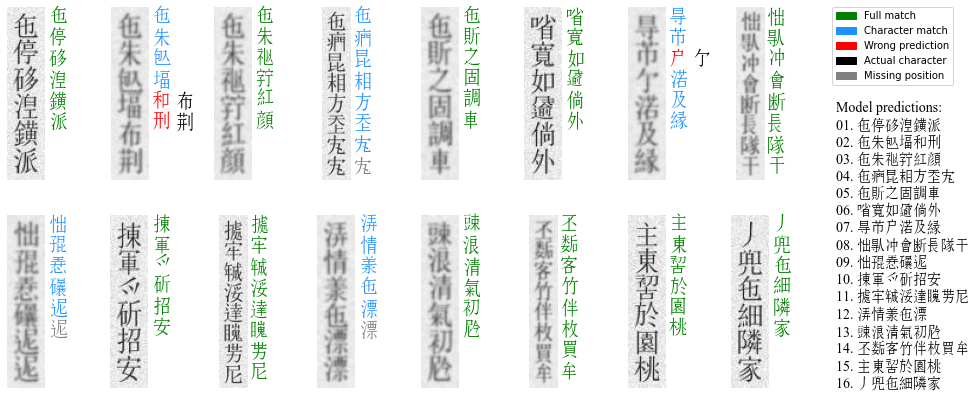

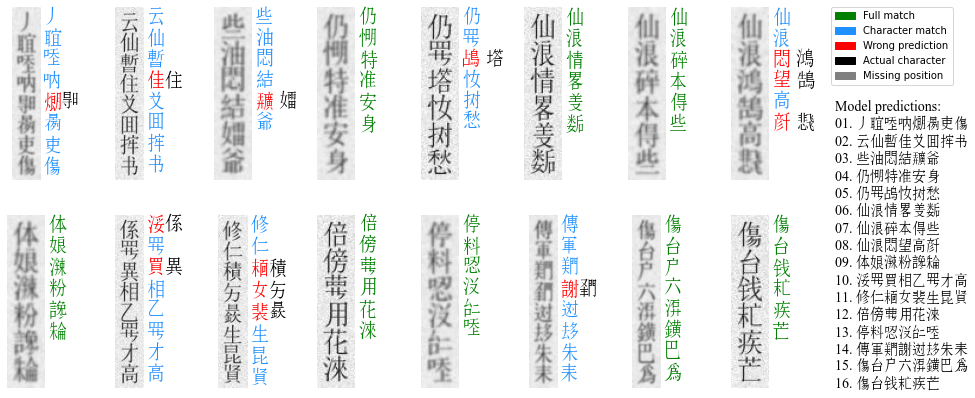

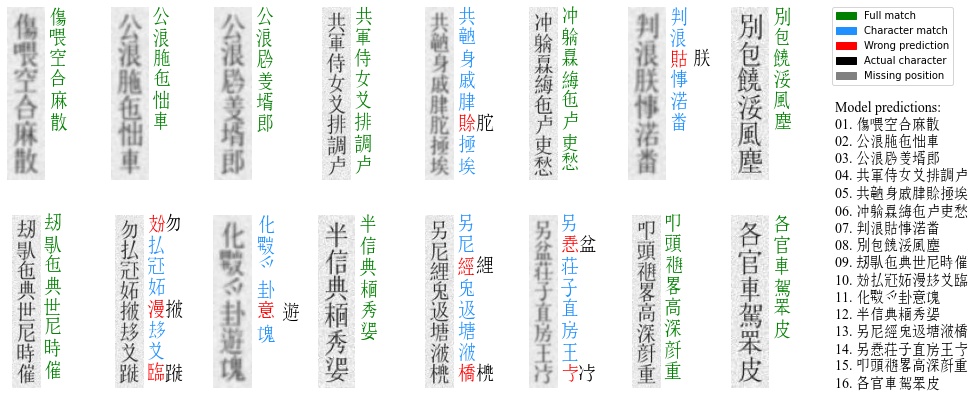

In [118]:
for idx, batch in enumerate(best_valid_dataset.take(3)):
    batch_images, batch_labels = batch['image'], batch['label']
    valid_idxs = best_valid_idxs[idx * BATCH_SIZE: (idx + 1) * BATCH_SIZE]
    valid_labels = []
    
    for label in batch_labels:
        # Gather indices where label != padding_token.
        not_padding = tf.math.not_equal(label, PADDING_TOKEN)
        indices = tf.gather(label, tf.where(not_padding))
        label = tf.strings.reduce_join(num2char(indices)) # Convert to string
        valid_labels.append(label.numpy().decode('utf-8'))
        
    preds = reloaded_prediction_model.predict(batch_images)
    pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
    visualize_images_labels(
        img_paths = img_paths[valid_idxs], 
        labels = valid_labels, 
        pred_labels = pred_labels,
        font_path = FONT_PATH, 
        text_x = WIDTH + 3 # Position of actual label to plot
    )
    print(f'Batch {idx + 1}: {valid_labels}\n')

## On random image

In [120]:
random_path = '../大越史記全書.jpg'
random_label = '大越史記全書'
random_image = process_images_labels(random_path, random_label)
batch_images = tf.expand_dims(random_image['image'], axis=0)
batch_labels = tf.expand_dims(random_image['label'], axis=0)

Predicted text: 大越史記全書


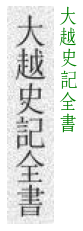

In [141]:
preds = reloaded_prediction_model.predict(batch_images)
pred_labels = decode_batch_predictions(preds, MAX_LENGTH, 20, num2char)
visualize_images_labels(
    img_paths = [random_path], 
    labels = [random_label], 
    pred_labels = pred_labels,
    figsize = (5, 4),
    subplot_size = (1, 1), 
    show_legend = False,
    font_path = FONT_PATH, 
    text_x = WIDTH + 3 # Position of actual label to plot
)
print('Predicted text:', ''.join(pred_labels))